# Object detection using YOLOv5 and DETR

Here we will use YOLOv5 and DETR to detect objects in images. We will use the [COCO dataset](https://cocodataset.org/#home). The evidence show which yolo is better compared to YOLOv5. Specifically, is faster and more accurate.

In [1]:
# load the refCOCOg dataset


!pip install gdown
import gdown

url = "https://drive.google.com/uc?id=1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq"
gdown.download(url)

!tar -xvf /content/refcocog.tar.gz

!rm /content/refcocog.tar.gz

import pickle
import numpy as np
import json
import matplotlib.pyplot as plt
import os

from PIL import Image

with open("./refcocog/annotations/refs(umd).p", "rb") as fp:
  annotations = pickle.load(fp)

  train_data = sorted([d for d in annotations if d["split"]=="train"], key=lambda d: d["file_name"])
  val_data = sorted([d for d in annotations if d["split"]=="val"], key=lambda d: d["image_id"])
  test_data = sorted([d for d in annotations if d["split"]=="test"], key=lambda d: d["image_id"])


  # image_ids = []
  # for d in train_data:
  #   d["file_name"] = os.path.join("./refcocog/images/", f"{d['file_name'][:-12]}.jpg")
    
  # for d in val_data:
  #   d["file_name"] = os.path.join("./refcocog/images/", f"{d['file_name'][:-12]}.jpg")
  
  # for d in test_data:
  #   d["file_name"] = os.path.join("./refcocog/images/", f"{d['file_name'][:-12]}.jpg")

  # print(len([d for d in train_data if d["image_id"]==9]))

  entry = train_data[0]

  print(json.dumps(entry, indent=4, default=str))

  # img = Image.open(entry["file_name"])

  # plt.title(entry["sentences"][0]["raw"])
  # plt.imshow(img)
  # plt.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From: https://drive.google.com/uc?id=1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
To: /content/refcocog.tar.gz
100%|██████████| 13.5G/13.5G [05:22<00:00, 41.8MB/s]


Streaming output truncated to the last 5000 lines.
./refcocog/images/COCO_train2014_000000419396.jpg
./refcocog/images/COCO_train2014_000000433336.jpg
./refcocog/images/COCO_train2014_000000567523.jpg
./refcocog/images/COCO_train2014_000000451554.jpg
./refcocog/images/COCO_train2014_000000439855.jpg
./refcocog/images/COCO_train2014_000000044594.jpg
./refcocog/images/COCO_train2014_000000194276.jpg
./refcocog/images/COCO_train2014_000000272463.jpg
./refcocog/images/COCO_train2014_000000485426.jpg
./refcocog/images/COCO_train2014_000000002774.jpg
./refcocog/images/COCO_train2014_000000346160.jpg
./refcocog/images/COCO_train2014_000000199829.jpg
./refcocog/images/COCO_train2014_000000210057.jpg
./refcocog/images/COCO_train2014_000000544117.jpg
./refcocog/images/COCO_train2014_000000440673.jpg
./refcocog/images/COCO_train2014_000000006151.jpg
./refcocog/images/COCO_train2014_000000514391.jpg
./refcocog/images/COCO_train2014_000000247459.jpg
./refcocog/images/COCO_train2014_000000141257.jpg

In [2]:
# print(json.dumps(test_data[0], indent=4, default=str))

from copy import deepcopy

d = deepcopy(test_data[0])

d["file_name"] = f'{"_".join(d["file_name"].split("_")[:3])}.jpg'

print(d["file_name"])

with open("./refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  print(data.keys())

  print(data["images"][0])

  t = sorted([d for d in data["annotations"]], key=lambda x: x["image_id"])

  print([d["image_id"] for d in t[:10]])

  for e in data["annotations"]:
    if e["id"]>=1000000 and e["id"]<1040000: #1038967
      print("BBOX = ",json.dumps(e["id"], indent=4))
      break

COCO_train2014_000000000656.jpg
dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])
{'license': 1, 'file_name': 'COCO_train2014_000000131074.jpg', 'coco_url': 'http://mscoco.org/images/131074', 'height': 428, 'width': 640, 'date_captured': '2013-11-21 01:03:06', 'flickr_url': 'http://farm9.staticflickr.com/8308/7908210548_33e532d119_z.jpg', 'id': 131074}
[9, 9, 9, 9, 9, 9, 9, 9, 25, 25]
BBOX =  1038967


In [3]:
import os
import json

from torch.utils.data import Dataset

class RefCOCOg(Dataset):
    def __init__(self, refs, annotations, split="train"):

        self.dataset = [{"file_name": os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": elem["sentences"][0]["raw"],
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]
    
    def __call__(self, idx):
        print(json.dumps(self.dataset[idx], indent=4))

In [4]:
# Load refs and annotations
import pickle

with open("./refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

with open("./refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

In [5]:
train_dataset = RefCOCOg(refs=refs, annotations=annotations, split="train")

print(train_dataset[0])
print(train_dataset)
print(len(train_dataset))
train_dataset(0)

{'file_name': './refcocog/images/COCO_train2014_000000519404.jpg', 'caption': 'Two woman one in black eatting and the other has a white shirt at the desk', 'ann_id': 1241542, 'bbox': [0.0, 45.95, 238.92, 408.64]}
42226
{
    "file_name": "./refcocog/images/COCO_train2014_000000519404.jpg",
    "caption": "Two woman one in black eatting and the other has a white shirt at the desk",
    "ann_id": 1241542,
    "bbox": [
        0.0,
        45.95,
        238.92,
        408.64
    ]
}


Caption:  Two woman one in black eatting and the other has a white shirt at the desk


(-0.5, 639.5, 479.5, -0.5)

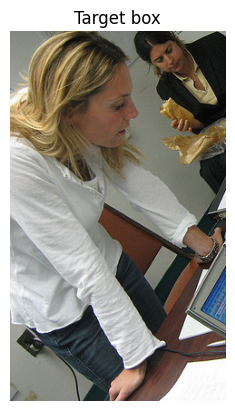

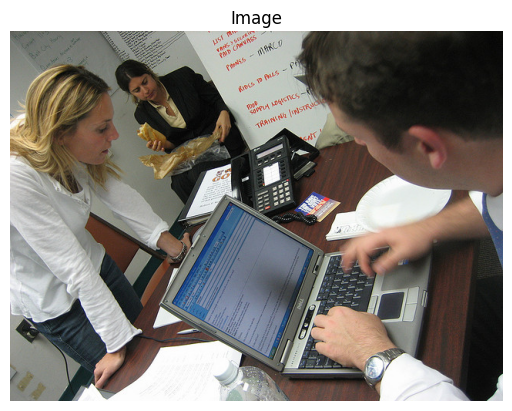

In [ ]:
# show an example of the crop

print('Caption: ',train_dataset[0]['caption'])


x_min = int(train_dataset[0]['bbox'][0])
x_max = x_min + int(train_dataset[0]['bbox'][2])

y_min = int(train_dataset[0]['bbox'][1])
y_max = y_min + int(train_dataset[0]['bbox'][3])

plt.imshow(plt.imread(train_dataset[0]['file_name'])[y_min:y_max,x_min:x_max])
plt.title('Target box')
plt.axis('off')

plt.figure()

plt.imshow(plt.imread(train_dataset[0]['file_name']))
plt.title('Image')
plt.axis('off')

In [ ]:
import matplotlib.pyplot as plt

def bring_crop(f_name, box, display = False):

  x_min = int(box[0])
  x_max = x_min + int(box[2])

  y_min = int(box[1])
  y_max = y_min + int(box[3])

  if display:
    # plot the box
    plt.imshow(plt.imread(f_name)[y_min:y_max,x_min:x_max])
    plt.title('Target box')
    plt.axis('off')
    return None
  
  return plt.imread(f_name)[y_min:y_max,x_min:x_max]

In [ ]:
# experiments with yolos

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection
import torch
from PIL import Image
import requests

url = train_dataset[0]['file_name']
image = Image.open(url)

image_processor = AutoImageProcessor.from_pretrained("hustvl/yolos-tiny")
model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-tiny")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[
    0
]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.3 MB/s eta 0:00:00


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Detected person with confidence 0.987 at location [383.42, 1.31, 639.86, 475.17]
Detected person with confidence 0.906 at location [0.37, 43.95, 250.66, 473.23]
Detected person with confidence 0.91 at location [0.37, 44.26, 233.26, 471.98]
Detected book with confidence 0.934 at location [375.51, 209.56, 436.31, 252.72]
Detected clock with confidence 0.945 at location [467.14, 421.48, 495.12, 453.69]
Detected person with confidence 0.98 at location [142.36, 38.31, 309.41, 232.33]
Detected laptop with confidence 0.994 at location [193.09, 211.71, 472.76, 449.58]


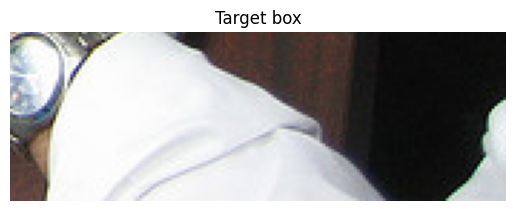

In [ ]:
# Detected clock with confidence 0.945 at location [467.14, 421.48, 495.12, 453.69]
# yolos is not precise
bring_crop(url, [467.14, 421.48, 495.12, 453.69], display = True)

# DL Grounding GINA implementation

Here we provide an implementation of a model which given the caption and an image give back the most likely box. Given the image using DETR we produce the boxes for each object. Moreover, using BLIP we produce for each box the caption. To capture which is the most likely cation we utilized a trick. We encoded the target caption and the caption of each box using CLIP. Subsequently, we measured the similarity with different metrics between the embodied representations. Then, we multiply pair wise the euclidean distance vector and the logits vector, obtained cheking the match with CLIP with the text and the box.

In [ ]:
# load detr

In [ ]:
import torch
model = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=True)
model.eval()

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s]
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/t

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [6]:
# source: https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_demo.ipynb#scrollTo=Y6Jrz6xz71C0
import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

In [ ]:
# first image
from PIL import Image


f_name = train_dataset[0]['file_name']
im = Image.open(f_name)

scores, boxes = detect(im, model, transform)

In [7]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    

# here we show the evindece of how much detr is precise 
# compared to yolo

In [ ]:
plot_results(im, scores, boxes)


In [8]:
import matplotlib.pyplot as plt

def bring_crop(f_name, box, display = False):

  x_min, y_min, x_max, y_max = box.tolist()

  if display:
    # plot the box
    plt.figure()
    plt.imshow(plt.imread(f_name)[int(y_min):int(y_max),int(x_min):int(x_max)])
    plt.title('Target box')
    plt.axis('off')
    return None
  
  return plt.imread(f_name)[int(y_min):int(y_max),int(x_min):int(x_max)]

In [ ]:
boxes_found_detr = [bring_crop(f_name, b) for b in boxes]
print('number of boxes found: ',len(boxes_found_detr))

number of boxes found:  11


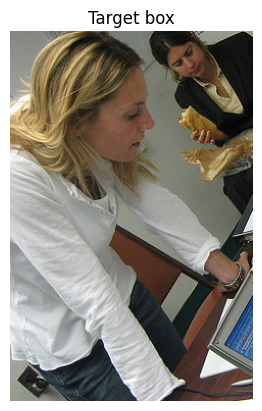

In [ ]:
bring_crop('.'+f_name, np.array([0.0,45.95,238.92,408.64]), display = True)